Import des librairies et donnees necessaires:
===

In [1]:
# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

# Libairies de representation graphique:
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

# Pour le K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Options globales pour l'output display:
pd.options.display.float_format = "{:.3f}".format

# Import des donnees:
Billet_df = pd.read_csv("billets.csv", sep = ';',)              #Training set
Billet_test_df = pd.read_csv("billets_production_test.csv")     #Testing set

Observation et nettoyage:
===

Billet_df:
---

In [2]:
# Resume des donnees brutes:
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1463.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.486,3.151,112.679
std,0.305,0.299,0.326,0.664,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.015,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


Nous avons bien six dimensions en plus de la colonne permettant de distinguer les vrais des faux billets qui ne sera pas présente dans nos données réelles. Les types des données sont ceux attendus. Il manque des données seulement pour margin_low, il s'agit de la marge entre le bord inferieur du billet et l'image de celui-ci (en mm).

In [3]:
# Identification des lignes ayant des donnees manquantes:
print(Billet_df.index[Billet_df.isnull().any(axis=1)])
print(Billet_df.isna().sum())

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


Il y a des données manquantes, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.

Régression linéaire:
===

Cette méthode est effectuée parce qu'elle à été demandée, mais dans la réalité, on parle de billet, de forme approximativement rectangulaire, il serait donc possible d'obtenir les valeurs manquantes en utilisant :
- La valeur du côté opposé
- Le théorème de pythagore (mais on suppose alors que l'angle mesure 90°.)

In [4]:
# Separation des donnees manquantes des donnees manquantes:
Reg_Lin_Train_df = Billet_df.dropna()
Reg_Lin_Test_df = Billet_df[Billet_df.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:
x_train = Reg_Lin_Train_df[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)

<ipython-input-4-4deb81914be5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)


In [5]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.8668228920543415
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


- **La valeur d'interception** est la valeur moyenne estimée de notre variable dépendante lorsque toutes nos valeurs de variables indépendantes sont égales à 0.
- **Pour les coefficients** Il y a 2 valeurs par variables. Elles représentent la relation de notre variable indépendante à la variable dépendante, où un changement d'exactement 1 à la variable indépendante changera la valeur de notre variable dépendante du même montant que le coefficient.

Validation du modèle:
---
Après avoir construit le modèle, il est important de valider ses performances.

In [6]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = Billet_df)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          2.60e-202
Time:                        14:55:43   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

- Prob(F-Statistic): L'hypothèse nulle du test de Fisher est que tous les coefficients sont nuls (significativité du modèle global =/= t significativité pour les variables). Ici, elle est très faible et inférieure au seuil alpha 5 % (ou 1 %), on rejet l'hypothèse nulle, notre modèle est meilleur que celui où les coefficients seraient nuls.
- Le R² ajusté (puisque nous avons un grand nombre de valeurs) n'est pas satisfaisant. (inférieur à 0,5). C'est est la partie de la variation totale de la variable dépendante qui est expliquée par la variation de la variable indépendante.
- Les coefficients: représentent le changement moyen de la variable de réponse pour une unité de changement dans la variable prédictive tout en .maintenant d’autres prédicteurs dans le modèle constant. Ainsi ici, si la longueur ("length") change d'une unité (1 mm), toute valeurs égales .par ailleurs, l'estimation de "margin_low" diminuera de 0,4091 mm en moyenne.

Test d'hypothèses par analyse des résidus:
===

Il y a plusieurs hypothèses à tester pour la régression linéaire :
- **Normalité de la distribution des résidus** : *Omnibus* test, l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de *Prob(Omnibus)* doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée, les coefficiants estimés ne seront pas BLUE. *Prob(Jacque-Bera)* est redondant avec Prob(Omnibus), une valeur élevée pour le *Jarque-Bera* indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un *test d'Aderson-Darling* qui nous indique que les résidus suivent une distribution Normale.
- **Homocédasticité** : les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de *White* permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de *White* qui est en fait un cas particulier du Breusch-Pagan. Il existe aussi le test de Goldfeld et Quandt qui n'est plus vraiment utilisé.
- **Non-autocorrélation** : l'autocorrélation est la corrélation des erreurs (résidus) dans le temps. *Durbin-Watson* < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < *Durbin-Watson* < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. *Durbin-Watson* > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. Ici, il est de 1.888, il n'y a donc pas d'autocorrélation.
- **Multicollinéarité** : on suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. Le *cond. No.* est élevée il semble qu'il y ai un problème de multicollinéarité. Le *VIF* indique effectivment une forte multicolinéarité.
- **Linéarité** : on fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante. Non verifée ici, les estimateurs ne seront pas BLUE (ils sont biaisés).
-
Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible alors que pour toutes les autres hypothèses, l'estimation est possible, mais donne un estimateur biaisé et/ou non efficace (à variance non-minimale) mais il existe des corrections possibles. La normalité des erreurs est non obligatoire, mais permet de tirer de bonnes propriétés. Elle est gardée dans ce projet parceque demandée dans l'évalutation mais elle n'est pas appropriée.

In [7]:
# La moyenne des residus est nulle:
res_lin.resid.mean()

-7.647926493516266e-14

-0.00000000000007 étant très proches de zéro, on peut considérer cette hypothèse comme validée.

In [8]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

# On est oblige d'enlever ''is_genuine'' puisque c'est une variables qualitative.

VIF par features:
 diagonal       170566.671
height_left    111895.310
height_right   100858.864
margin_up         261.969
length          22708.223
dtype: float64
VIF moyen: 81258.20741161003


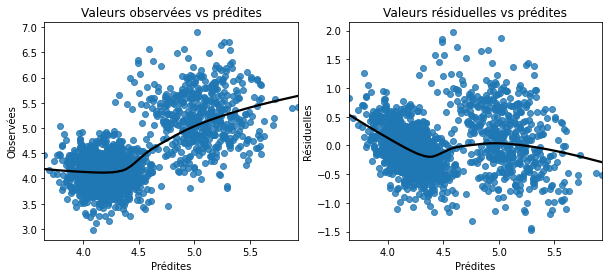

In [9]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(res_lin, Reg_Lin_Train_df["margin_low"])

La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée.
Solutions potentielles :
- Transformation non-linéaire sur les variables dépendantes/indépendantes.
- Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).
- Ajout de features non considérées précédemment.

<ipython-input-10-3590cb80c152>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]


La p-value du test d'Aderson-Darling vaux 3.9857722331535204e-05


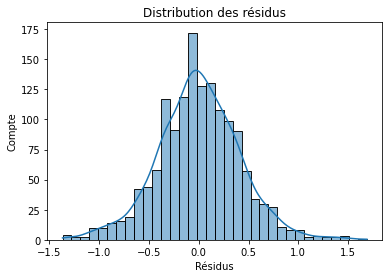

In [10]:
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(Reg_Lin_Train_df["residual"])[1])

# Graphique:
sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

Une p-value inférieure à alpha pour le test d'Anderson-Darling indique que l'hypothèse nulle de normalité de la distribution des résidus est rejetée. Ici, l'hypothèse n'est pas rejetée puisque la p-value obtenue est inférieure au seuil alpha 5 % (ou 1 %), les résidus suivent une distribution Normale.

{'Test Statistic': 109.8601519685901, 'p-value': 2.082824499042204e-14, 'F-Statistic': 5.853731207797142, 'F-Test p-value': 4.9748650928658e-15}


Text(0.5, 1.0, 'Homoscédasticité')

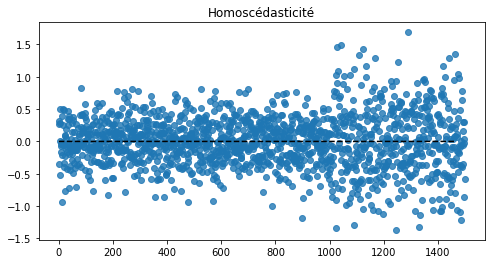

In [11]:
# Homoscedasticite:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

La répartition semble aléatoire sur le graphique.
L'hypothèse nulle du test de *White* est qu'il y a homoscédasticité (les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante), l'hypothèse alternative est qu'il y a hétéroscédasticité. On fixe un seuil alpha de 5 % (ou 1 % dans les deux cas ok, mais plus restrictif, voir selon le taux d'erreur acceptable non précisé dans le cahier des charges). La p-value est ici très inférieure au seuil, on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 % (ou 1 %).

C:\Users\leroc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,margin_low,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.520,0.038,0.011,-0.041,-0.051,0.028,-0.018,0.001,-0.564,0.017,-0.073,-0.563,-0.073
1,3.770,-0.048,0.032,0.041,0.007,0.006,0.006,0.001,-0.770,0.006,-0.060,-0.770,-0.060
2,4.400,-0.029,0.034,0.028,-0.020,-0.011,-0.001,0.000,0.572,0.008,0.052,0.572,0.052
3,3.620,-0.032,0.061,0.001,-0.016,0.006,-0.030,0.001,-1.119,0.004,-0.075,-1.119,-0.075
4,4.040,-0.026,0.021,-0.027,0.056,-0.049,-0.010,0.001,-1.121,0.006,-0.084,-1.121,-0.084


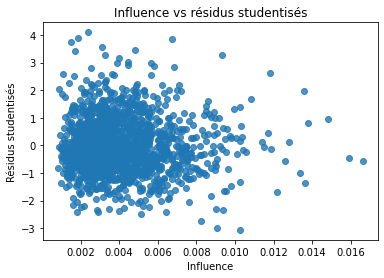

In [12]:
# Identification des individus atypiques et influents (iai), preambulle:
student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

# Graphique:
sns.regplot(leverage, res_lin.resid_pearson, fit_reg=False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")

# Creation d'un dataframe de travail:
iai_df = pd.concat([Reg_Lin_Train_df["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
iai_df = iai_df.rename(columns={"hat_diag": "leverage"})                                               #hat_diag = leverage donc on change le nom
iai_df.head()

- **influence.resid_studentized_external** : résidus studentisés en externe, permettent de détecter les valeurs aberrantes, observations qui possèdent des valeurs extrêmes sur l'ensemble des prédicteurs ou la variable dépendante.
- **influence.cooks_distance** : distance de Cook, utilisée pour estimer l'influence d'une donnée lors de l'utilisation de méthodes des moindres carrés.
- **influence.dffits** : DFFITS statistics ("difference in fit(s)"), c'est une méthode de diagnostique de l'influence d'un point dans une régression.
- **influence.hat_matrix_diag** : la diagonale de projection, ou "hat". La mtatrice hat décrit l'influence de chaque valeur dépendante sur chaque valeur estimée. Sa diagonale correspond aux 'leverages', qui décrivent l'influence de chaque valeur sur l'estimation pour la même observation.

[détails de la méthode .influence](https://thequackdaddy.github.io/statsmodels.github.io/0.9.0/_modules/statsmodels/stats/outliers_influence.html)

In [13]:
# Studentisation des residus:
std_res = iai_df.student_resid
print ("résidus studentisés:\n", std_res.describe())

# Individus atypiques:
outlier = pd.DataFrame((iai_df["margin_low"][abs(std_res) > 2]))
print(outlier.count())

résidus studentisés:
 count   1463.000
mean       0.000
std        1.001
min       -3.088
25%       -0.661
50%       -0.087
75%        0.570
max        4.127
Name: student_resid, dtype: float64
margin_low    72
dtype: int64


Nous trouvons donc 72 individus atypiques (résidus studentisés > 2 en valeur absolue), dans les faits, on ne supprime les outliers que s'ils sont influents. Les points a forte influence sont qui se placent au-dessus du seuil (2*k) +2/n avec k = nombre de variables explicatives et n = nombre d'observations.

In [14]:
# Identification des individus a forte influence:
k_reg_lin = 5                                       # k = nombre de variables predictives pour la regression lineaire +1 si on a une constante
n_reg_lin = 1500                                    # n = nombre d'observations
lev_thr = ((2*k_reg_lin)+2)/n_reg_lin               #=0.047 Seuil (threshold), toutes valeurs au dessus aura une forte influence

print(iai_df["leverage"].describe())

hg_leverage = iai_df["margin_low"][abs(iai_df["leverage"]) > lev_thr]
print("nombre d'individus à forte influence:", hg_leverage.count())

count   1463.000
mean       0.004
std        0.002
min        0.001
25%        0.003
50%        0.004
75%        0.005
max        0.017
Name: leverage, dtype: float64
nombre d'individus à forte influence: 79


Il y a donc 79 individus influents. Il faut maintenant recouper les individus atypiques et influents pour identifier les individus ayant un impact sur la régression linéaire.

In [15]:
# Identification des individus atypiques a forte influence:
outliers_hg_lev =pd.merge(outlier,hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

margin_low_x    7
margin_low_y    7
dtype: int64
      margin_low_x  margin_low_y
664          5.040         5.040
965          3.450         3.450
1074         4.360         4.360
1089         3.860         3.860
1199         4.490         4.490
1329         3.820         3.820
1478         6.080         6.080


Il y a au final 7 individus à la fois influents et atypiques. On supprime les individus influents et on relance la régression linéaire.

In [16]:
# Suppression des iai:
Billet_sans_iai_df = Billet_df.drop(outliers_hg_lev.index)

# Instanciation:
reg_lin_c = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = Billet_sans_iai_df)

# Calculs:
model_reg_lin_b = reg_lin_c.fit()
print(model_reg_lin_b.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     282.2
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          5.39e-211
Time:                        14:55:58   Log-Likelihood:                -972.21
No. Observations:                1456   AIC:                             1956.
Df Residuals:                    1450   BIC:                             1988.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.2866      9.516      2.552   

- Le R² (ajusté ou non) augmente légèrement (0.47 à 0.49).
- La F-stat passe de 2661 à 2822 avec un changement d'ordre de grandeur de la Prob de -202 à -211.
- L'AIC passe de 2015 à 1956.
- Le BIC de 2046 à 1998.
- Le log diminue de -1001.3 à -972.21.
- Les coefficients et leurs statistiques restent eux globalement inchangés.

Le nombre d'individus influents et atypiques est faible (7/1463), ils n'influencent finalement pas tant le jeu de données et leur suppression n'apporte pas beaucoup au modèle, la décision est prise de continuer avec eux tout en gardant leur présence à l'esprit. Il est toujours possible d'utiliser, si nécessaire, Billet_sans_iai_df à la place de Billet_df.

Application du modèle:
---

In [17]:
# Application du modele sur les donnees test
x_test = Reg_Lin_Test_df[["is_genuine","diagonal","height_left","height_right", "margin_up","length"]]
Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)

# Concatenation:
reg_lin_result = [Reg_Lin_Test_df, Reg_Lin_Train_df]
Billet_df = pd.concat(reg_lin_result)
Billet_df = Billet_df.drop(["margin_low_pred", "residual"], axis=1)
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


<ipython-input-17-b12f73b1cd47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.027,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


Il n'y a plus de valeurs manquantes et très peu de changement au niveau général (pour margin_low le premier quartile passe de 4.01 à 4.03).

Analyse descriptive:
===

In [18]:
# Resume des donnees apres regression lineaire:
Billet_df.info()
Billet_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 72 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.027,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         500        500     500
True            1000         1000          1000        1000       1000    1000


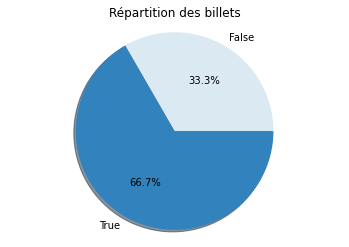

In [19]:
# Repartition des vrais/faux billets dans notre dataset d'apprentissage:
print(Billet_df.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(Billet_df.groupby(["is_genuine"])["diagonal"].count(),
        labels=["False","True"],
        autopct="%1.1f%%",
        colors=["#dbe9f3","#3182bd"],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition des billets")
plt.show()

#On compte n'importe quelle dimension pour le graphique (ici "diagonal") puisqu'elles sont toutes presentes une fois sur chaques billets.

In [20]:
# Billets moyens selon l'authenticitee:
print(Billet_df.groupby(["is_genuine"]).mean())

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False        171.901      104.190       104.144       5.216      3.350 111.631
True         171.987      103.949       103.809       4.116      3.052 113.202


La forme globale de ces billets, vrais ou faux, n'est pas commune, ils sont plus proches de carrés que nos billets habituels, par exemple en France les mesures théoriques des billets s'étendent de 120 à 160 mm de longueur et de 62 à 82 mm de hauteur.
Qui plus est les diagonales sont impossibles (théorème de pythagore):
- ex: Billet 72 : diag = 171.94 ht = 103.89 lg = 112.79 mais √(112.79²+103.89²) = 153.34.
Comme l'exemple de la monnaie française le montre, que dans notre jeux de données, il est probable qu'il n'y a qu'un seul type de billet puisque les variations des mesures sont minimes (std =	0.31	0.30	0.33	0.66	0.23	0.87).

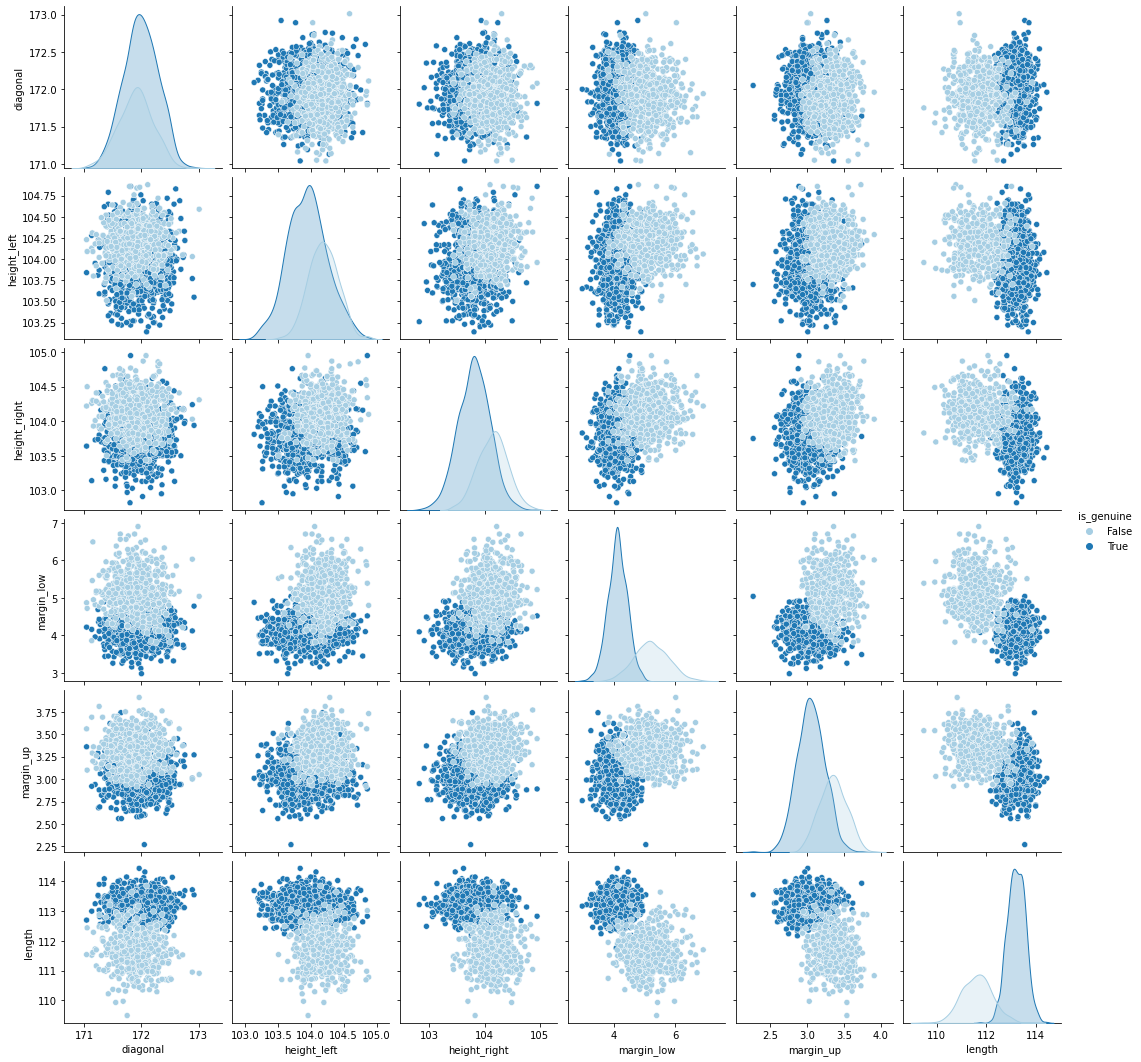

In [21]:
# Pair plot:
sns.pairplot(Billet_df, hue="is_genuine", palette="Paired")

Certains points paraissent particulièrement éloignés de leurs groupes, nous allons donc essayer d'identifier les outliers dans notre jeu de données.
Les dimensions qui permettent vraiment de distinguer les vrais des faux billes sont length et margin_low. (cf densités sur la diagonale qui ne se recouvrent que très peut). On retient donc ces variables comme meilleures candidates, mais on garde toutes les variables pour les analyses suivantes pour avoir une approche plus naïve des algorithmes. Dans un projet sans cahier des charges, la création de fonctions de classification reposant sur length et margin_low serai suffisante pour différencier les vrais des faux billets.
On remarque également que la sortie de ce graphique peut être un peu longue pour finalement assez peu de données (moins de 1500), c'est un problème por l'optimisation.

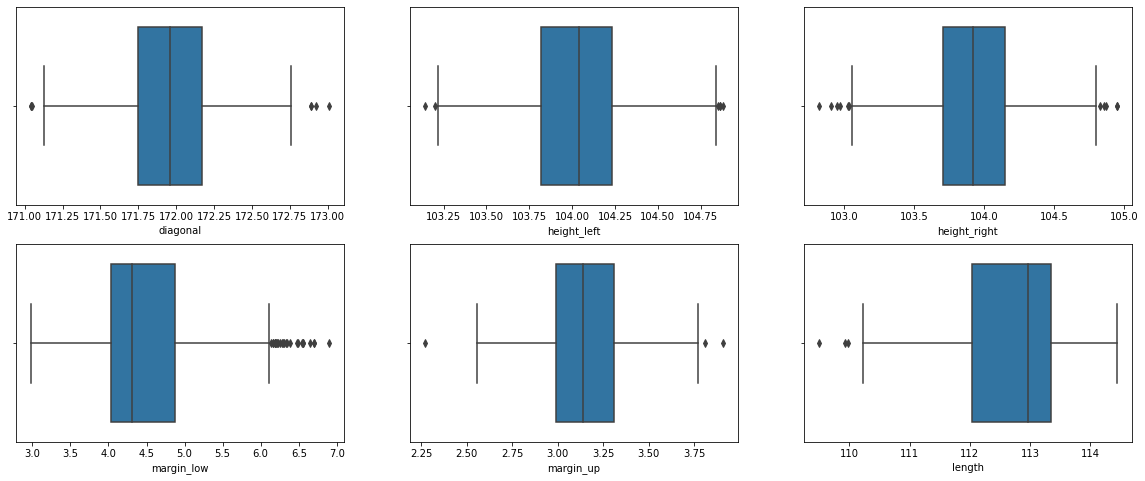

In [22]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation

fig = plt.figure(figsize=(20,8))

for i in Billet_df.loc[:, Billet_df.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    #plt.title('{} (boxplot)'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(x = Billet_df[i])
    c = c + 1
plt.show()

On voit qu'il y a effectivement, pour toutes les dimensions, des outliers que l'on va identifier mathématiquement pour plus de précision.

In [23]:
# Detection numerique des outliers:
q1 = Billet_df.loc[:, Billet_df.columns != "is_genuine"].quantile(q=0.25, interpolation="midpoint")
q3 = Billet_df.loc[:, Billet_df.columns != "is_genuine"].quantile(q=0.75, interpolation="midpoint")
iq = q3 - q1

lim_outliers_inf = q1-1.5*iq
lim_outliers_sup = q3+1.5*iq

#outliers_inf = Billet_df.loc[:, Billet_df.columns != "is_genuine"] < lim_outliers_inf
#outliers_sup = Billet_df.loc[:, Billet_df.columns != "is_genuine"] > lim_outliers_sup
#passer par les index des billets si suppression nécessaire

Nous ne les supprimerions pas avant la régression logistique puisque nous ne savons pas comment ils se comportent, il faudra cependant faire une 
étude des individus atypiques et influents.

Régression logistique:
===

Nous cherchons à mettre en place un modèle prédictif à l'aide de données annotées, le but étant d'expliquer une variable qualitative binaire (Vrai/faux) par des variables aléatoires quantitatives (mesures en millimètre), il faut donc faire une régression logistique. On commence par isoler la variable cible des autres.

In [24]:
# y (authenticite): 
y_billet = Billet_df.loc[:, Billet_df.columns == "is_genuine"]
print(y_billet.value_counts())                                  #Comptage des modalites de y

# X (les autres):
X_billet = Billet_df.loc[:, Billet_df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                      #Il faut ajouter une constante dans Statsmodels
print(X_billet.head())


is_genuine
True          1000
False          500
dtype: int64
     const  diagonal  height_left  height_right  margin_low  margin_up  length
72   1.000   171.940      103.890       103.450       4.065      3.250 112.790
99   1.000   171.930      104.070       104.180       4.112      3.140 113.080
151  1.000   172.070      103.800       104.380       4.134      3.020 112.930
197  1.000   171.450      103.660       103.800       3.994      3.620 113.270
241  1.000   171.830      104.140       104.060       4.140      3.020 112.360


In [25]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.026349
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Feb 2022   Pseudo R-squ.:                  0.9586
Time:                        14:56:48   Log-Likelihood:                -39.524
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -230.4143    249.954     -0.922      0.357    -720.316     259.487
diagonal         0.256

L'algorithme de [Newton-Raphson](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html) est utilisé par défaut.

10 itérations ont été nécessaires pour maximiser la log-vraisemblance.

Le warning est dû au fait que le modèle apprend "trop bien", il y a des variables qui prédisent parfaitement y, ce n'est pas réaliste, cela vient du fait que nos données sont très artificielles, il y a donc peu d'erreur.

Il y a des variables x non-significatives au seuil alpha 5 % (si on prend alpha 1 %, on enlèvera height_right en plus), on recommence la régression sans ces variables (diagonal, height_left, height_right).

In [26]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = Billet_df[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.958   
Dependent Variable:   is_genuine       AIC:              90.4453 
Date:                 2022-02-15 14:56 BIC:              117.0114
No. Observations:     1500             Log-Likelihood:   -40.223 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -285.3339 139.1600 -2.0504 0.0403 -558.0825 -12.5852
height_right   -3.3223   1.1166 -2.9752 0.0029   -5.5109  -1.1337

- LLR p-value est inférieure à 0.05, le modèle est significatif dans son ensemble.
- Le pseudo R² est très proche de 1, notre modèle explique donc la majorité de la variance observée.
- Les coefficients : l'interprétation des coefficients estimés dépend de la fonction de liaison, de l'événement de référence et des niveaux de facteur de référence. Une estimation de coefficient associée à un prédicteur (facteur ou covariable) représente la variation de la fonction de liaison ln(μi/(1−μi)) pour chaque variation d'unité du prédicteur, tous les autres prédicteurs étant maintenus constants. our la fonction de liaison logit, le logarithme népérien des probabilités de succès est fonction des coefficients estimés:
ln [P(événement)/P(non événement)] = β0 + β1x1 + β2x2 + ... + βnxn
Plus le logarithme des probabilités de succès est important, plus l'événement de référence est probable. Ainsi, des coefficients positifs indiquent que la probabilité de l'événement augmente, tandis que des coefficients négatifs indiquent qu'elle diminue. Nos prédicteurs sont ici tous continus; Ainsi si 'length' augmente d'une unité (1 mm), le logarithme néperien augmente de 6.1579. Les coéficients positif font donc augmenter le ln tandis que les négatifs le font diminuer.
On peut également utiliser les estimations de coefficient pour calculer les rapports des probabilités ou le rapport entre deux probabilités de succès. Le coefficient se lit comme le logarithme de l’Odds ratio consécutive à l’augmentation d’une unité de la variable explicative. Ici, étrangement, l’augmentation de 'length' d’une unité (1 mm), toutes valeurs égales par ailleurs, va augmenter le risque de que le billt soit faux de OR = EXP(6.1579)= 472.4349.

Test hypothèses :
---
Lorsque l'on fait une régression logistique, on fait plusieurs hypothèses :
- **La taille de l'échantillon** doit être suffisante, ici > 1000. En règle générale, on souhaite avoir plus de 500 observations indépendantes et plus de 20 observations pour l'outcome la moins fréquente. C'est le cas ici puisque nous avons 1500 observations dont 500 faux billets.
- **significativité des variables** : seules les variables significatives sont incluses, on doit donc enlever les autres (cf ci-dessus pour la suppression des variables dont la p-value était inférieure au seuil). On peut également regarder les p-value du *test de Wald*, celles inférieures au seuil (classiquement 0,05) ne sont pas significatives.
- **Indépendance des observations** : les observations sont indépendantes : ici, c'est le cas, chaque billets étant uniques et indépendants des autres.
- **Binaire** : La régression logistique binaire nécessite que la variable dépendante soit binaire. Ici is_genuine ne peut prendre que deux valeurs, l'hypothèse est vérifiée. Le 'factor level' 1 correspond à l'outcome souhaité (faux ?).
- **Multicollinéarité** : minimale ou nulle entre les varaibles indépendantes. *Test avec VIF* (variance inflation factor)
- **Linéarité avec les log-odds** : les variables indépendantes ont une relation linéaire avec les log-odds. *Test Box-Tidwell*. Cette hypothèse est critique et n'est pas vérifiée ici, mais du fait du cahier des charges nous nous en tenons à un modèle de régression logistique quand même.
- Pas d'outliers** : individus influents aberrants. Se vérifie avec l'IQR, du z-score ou peut être visualisé à l'aide de graphiques en boîte ou en violon.

In [27]:
# Test de Wald:
print("avant élimination des variables non-significatives:\n", res_log.wald_test_terms())
print("après élimination des variables non-significatives:\n", model_reg_log.wald_test_terms())

avant élimination des variables non-significatives:
                chi2  P>chi2  df constraint
const         0.850   0.357              1
diagonal      0.051   0.821              1
height_left   1.322   0.250              1
height_right  6.415   0.011              1
margin_low   37.199   0.000              1
margin_up    21.797   0.000              1
length       45.578   0.000              1
après élimination des variables non-significatives:
                chi2  P>chi2  df constraint
const         4.204   0.040              1
height_right  8.852   0.003              1
margin_low   42.868   0.000              1
margin_up    22.437   0.000              1
length       48.087   0.000              1


On confirme ici que nous n'avons gardé que les variables significatives.

In [28]:
# Test binarite:
print(Billet_df["is_genuine"].nunique())

2


Il n'y a bien que deux valeurs possibles pour la variable prédite.

In [29]:
# Test Box-Tidwell:
var_cont = ["height_right","margin_low","margin_up","length"]                                    #Les autres ne sont pas dans le modele

# Ajout de variables transofrmees (logarithme neprien):
for var in var_cont:
    Billet_df[f'{var}:log_{var}'] = Billet_df[var].apply(lambda x: x * np.log(x))

# On ne garde que les colonnes concernant les variables continues:
cols_to_keep = var_cont + Billet_df.columns.tolist()[-len(var_cont):]

# Inclusion des ln dans les variables:
X_lt = Billet_df[cols_to_keep]
X_lt = sm.add_constant(X_lt, prepend=False)
y_lt = Billet_df["is_genuine"]

# Construction du modele:
logit_results = GLM(y_lt, X_lt).fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1491
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                        0.035251
Method:                          IRLS   Log-Likelihood:                 385.05
Date:                Tue, 15 Feb 2022   Deviance:                       52.560
Time:                        14:56:50   Pearson chi2:                     52.6
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
height_right  

En principe, selon le test de Box-Tidewell, si le coefficient Z est significatif pour les log_x cela signifie que la variable x intervient de manière non-linéaire sur le LOGIT. On regarde donc les p-value pour les log_x.

Pour log_margin_up et log_length, p-val de Z est inférieure à 0,05, ces variables sont donc significatives, l'hypothèse nulle de linéarité n'est donc pas vérifiée. On ne connaît cependant pas quelle forme prend la relation. Il faudrait corriger cela (introduction d'un terme polynomial pour prendre en compte à non-linéarité???) linéariser problème interprétation en prenant en compte. (ex si log alors expo)

En revanche pour log_margin_low et log_height_right, la p-value de Z est supérieure à 0,05, ces variables sont donc non significatives, l'hypothèse nulle de linéarité ne peut être rejetée.

PROBLÈME : margin_low et lenght avaient été identifiées comme discriminantes par le pair-plot, mais length devrait ici être abandonnée au profit de height_right...
Estimation par noyaux d'une fonction non-paramétrique pour enlever la forme linéaire obligatoire

Dans le projet on chercher surtout à mesurer la performance du modèle (les tests se sont perdus en pratique, on s'oriente plus en performance.)
Performance = capacité à prédire correctement (matrice de confusion qui n'est pas le meilleur indicateur)). Le test des hypothèses n'est pas prioritaire, mais on soulèvera ce problème en ouverture.

In [30]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(X_billet.values, i)
               for i in range(X_billet.shape[1])],
              index=X_billet.columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 const          185267.941
height_right        1.246
margin_low          1.890
margin_up           1.410
length              2.109
dtype: float64
VIF moyen: 37054.91945740548


Aucune des variables n'a de VIF supérieur à 5.
Il n'y a doc pas de collinéarité

In [31]:
# On ne garde que les variables qui passent le Box-Tidewell test:
X_billet_a = Billet_df[["height_right","margin_low"]]
X_billet_a = sm.add_constant(X_billet_a)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet_a)

# Creation du modele:
model_reg_log_a = reg_log.fit()

# Resume des resultats:
print(model_reg_log_a.summary2())

Optimization terminated successfully.
         Current function value: 0.179318
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.718      
Dependent Variable: is_genuine       AIC:              543.9536   
Date:               2022-02-15 14:56 BIC:              559.8932   
No. Observations:   1500             Log-Likelihood:   -268.98    
Df Model:           2                LL-Null:          -954.77    
Df Residuals:       1497             LLR p-value:      1.4563e-298
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
------------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------
const          414.2970  44.2654   9.3594 0.0000 327.5385 501.0556
height_right    -3.7018   0.4214  -8.7848 0.0000  -4.

Si on décidait d'ulitiser ce modèle on perdrait en pseudo-R² (0.95 pour model_reg_log).
On aurait pour la matrice de confusion en pourcentage:
-[29.13333333  4.2       ]
-[ 2.33333333 64.33333333]

-Précision: 0.9346666666666666
-Spécificité: 0.938715953307393
-Sensibilité: 0.965
-Score F1: 0.965

Des odds ratio:
-height_right                                                0.025
-margin_low                                                  0.002

-Une aire sous la courbe de 0.97

Diagnostique des résidus:
---

Je n'arrive pas à avoir get_influence qui est utilisé sur toutes les méthodes d'identification des individus atypiques/influents que j'ai vu ou utilisé précédemment. En parallèle des prochains projets, je continuerais à chercher une solution, mais ce ne sera pas fait avant la soutenance.

In [32]:
print(dir(model_reg_log))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_data_attr', '_data_in_cache', '_get_endog_name', '_get_robustcov_results', '_use_t', 'aic', 'bic', 'bse', 'conf_int', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'f_test', 'fittedvalues', 'get_margeff', 'initialize', 'k_constant', 'llf', 'llnull', 'llr', 'llr_pvalue', 'load', 'mle_retvals', 'mle_settings', 'model', 'nobs', 'normalized_cov_params', 'params', 'pred_table', 'predict', 'prsquared', 'pvalues', 'remove_data', 'resid_dev', 'resid_generalized', 'resid_pearson', 'resid_response', 'save', 'scale', 'set_null_options', 'summary', 'summary2', 't_test', 't_test_pairwise', 'tvalues', 'use_t', 'wald_t

In [33]:
print(dir(reg_log))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_perfect_pred', '_check_rank', '_continuous_ok', '_data_attr', '_derivative_exog', '_derivative_exog_helper', '_derivative_predict', '_fit_collinear', '_fit_zeros', '_formula_max_endog', '_get_init_kwds', '_handle_data', '_init_keys', 'cdf', 'cov_params_func_l1', 'data', 'df_model', 'df_resid', 'endog', 'endog_names', 'exog', 'exog_names', 'fit', 'fit_regularized', 'from_formula', 'hessian', 'information', 'initialize', 'k_constant', 'loglike', 'loglikeobs', 'pdf', 'predict', 'raise_on_perfect_prediction', 'score', 'score_obs']


Application du modèle:
---

In [34]:
# Suppression des colonnes inutiles:
Billet_df = Billet_df.drop(["margin_low:log_margin_low","height_right:log_height_right","margin_up:log_margin_up","length:log_length"], axis=1)

In [35]:
# Application du modele sur les donnees training:
Billet_df["proba"] = model_reg_log.predict(X_billet)
Billet_df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
Billet_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.940,103.890,103.450,4.065,3.250,112.790,0.998,1
99,True,171.930,104.070,104.180,4.112,3.140,113.080,0.998,1
151,True,172.070,103.800,104.380,4.134,3.020,112.930,0.997,1
197,True,171.450,103.660,103.800,3.994,3.620,113.270,0.989,1
241,True,171.830,104.140,104.060,4.140,3.020,112.360,0.965,1


Evaluation du modèle:
---

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

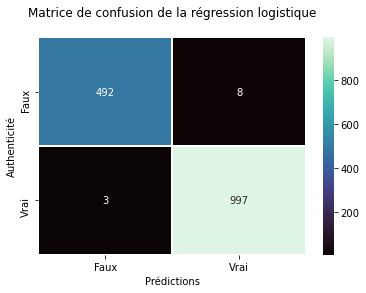

In [36]:
# Matrice de confusion:
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique\n")

In [37]:
print("Précision:",accuracy_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Spécificité:",precision_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Sensibilité:",recall_score(Billet_df["is_genuine"], Billet_df["y_pred"]))
print("Score F1:",recall_score(Billet_df["is_genuine"], Billet_df["y_pred"]))

Précision: 0.9926666666666667
Spécificité: 0.9920398009950249
Sensibilité: 0.997
Score F1: 0.997


Notre modèle est quasiment parfait puisque tous les scores s'approchent de 1. Ce n'est pas très réaliste, mais cela prouve qu'il fonctionne.

Accuracy : (précision) ratio de prédictions justes. C'est une bonne mesure si le jeu de données est symétrique et si les faux positifs et faux négatifs ont la même importance/le même poid.
Accuracy = TP+TN/total

Precision : (spécificité) ratio de vrais positifs sur le total des prédictions positives.
Precision = TP/TP+FP

Recall : (sensibilité) - Le ratio de positif prédit correctement parmi tous les positifs.
Recall = TP/TP+FN

F1 score - c'est une moyenne pondérée de la sensibilité et de la spécificité. On prend donc en compte les faux positifs et les faux négatifs en compte. Ce score, bien que moins intuitif que la précision est plus juste en particuliers pour les jeux de données dissymétriques.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [38]:
# Odds Ratios:
print("Les Odds ratio sont:\n", np.exp(model_reg_log.params))
# utile pour parler en terme de risque

Les Odds ratio sont:
 const            0.000
height_right     0.036
margin_low       0.002
margin_up        0.000
length         472.414
dtype: float64


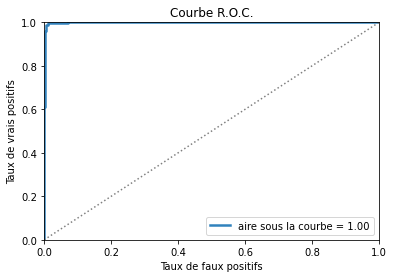

In [39]:
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(Billet_df["is_genuine"],Billet_df["proba"])
roc_auc = roc_auc_score(Billet_df["is_genuine"],Billet_df["proba"])

# Graphique:
plt.title("Courbe R.O.C.")
plt.plot(fpr,
        tpr,
        color="#3182bd",
        linewidth=2.5,
        label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

Comme avec les metrics calculées plus haut, on retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.

Application du modèle aux données test:
---

In [40]:
# Prediction sur des donnes inconnues:
X_test = Billet_test_df[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
Billet_test_df["proba"] = model_reg_log.predict(X_test)
Billet_test_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(Billet_test_df[["id","proba","y_pred"]])

# Affichage des resultats:
print("\nIndetification des billets:")
for i, k in zip(Billet_test_df["y_pred"],Billet_test_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

    id  proba  y_pred
0  A_1  0.000       0
1  A_2  0.000       0
2  A_3  0.000       0
3  A_4  0.996       1
4  A_5  1.000       1

Indetification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


Il y a donc une prédiction de trois billets faux (0) et de deux vrais (1).

K-means:
===

Nous passons l'étape de détermination du nombre de clusters optimal puisque nous cherchons ici à en avoir 2 (vrai et faux).

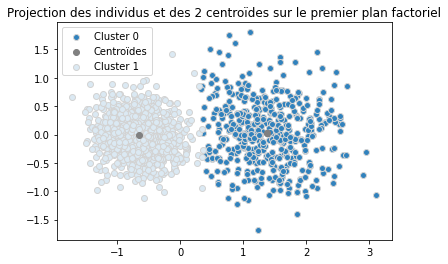

is_genuine  False  True 
row_0                   
0             481      2
1              19    998


In [41]:
# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
#Billet_df["cluster_km"] = km.labels_
#Billet_df["cluster_km"] = Billet_df["cluster_km"].apply(str)

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(Billet_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

#Verrfication de la classification: Matrice de confusion:
km_matrix = pd.crosstab(clusters_km,Billet_df["is_genuine"])
print(km_matrix)

Text(0.5, 1.0, 'Matrice de confusion K-means\n')

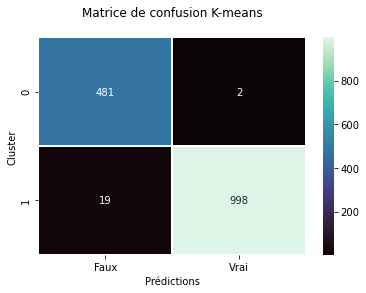

In [42]:
# Graphique:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

Comme attendu, notre classification n'est pas parfaite, globalement le premier cluster semble plus correspondre aux faux billets pendant que le second correspond plus au vrai.

In [43]:
# Predictions sur des donnees inconnues:
x_test_km = Billet_test_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

Billet_test_df["cluster_pred"] = km.predict(x_test_km)
print(Billet_test_df[["id","cluster_pred"]])

    id  cluster_pred
0  A_1             0
1  A_2             0
2  A_3             0
3  A_4             1
4  A_5             1


On obtient la même classification qu'avec la régression logistique.

In [44]:
# On supprime les colonnes devenues inutiles:
Billet_df = Billet_df.drop(["proba", "y_pred"], axis=1)

# Sauvegarde fichier Billet_df complete si necessaire:
# Billet_df.to_csv("billet_comlpet.csv")

Tentative pipeline : pas le temps avant soutenance = faire en parallèle de la recherche d'emplois pour ajouter au porte-folio/github et avoir la compétence (niv. basique). Pour la régression linéaire, il faudra alors utiliser une boucle pour changer toutes les valeurs de NaN peu importe leur colonne.